# Philadelphia Crime Data Example
## Reading the Data
Below we load in a data set of crimes incidents in the Philadelphia area and the divide the sets into all crime events and theft crime events. Using pyscan we can then extract approximate regions of interest at scale.

In [17]:
import pyscan
import csv
import numpy as np
import matplotlib.pyplot as plt
import random

def get_coord(i, lst):
    return [pt[i] for pt in lst]

query = "assault"

baseline = []
measured = []
with open("police_inct.csv", "r") as f:
    reader = csv.DictReader(f)
    numAnomalies = 0
    for row in reader:
        try:
            x = float(row["POINT_X"])
            y = float(row["POINT_Y"])
            if not (39.8 < y < 40.2 and -76 < x):
                continue
        except:
            continue
            
        point = pyscan.WPoint(1.0, x, y, 1.0)
        baseline.append(point)
        if "thefts" in row["TEXT_GENERAL_CODE"].lower():
            measured.append(point)
            

We can plot the data set to see the distribution of the theft vs. the background crime. In the below example we shuffle the points so that measured points or baseline points are systematically drawn over.

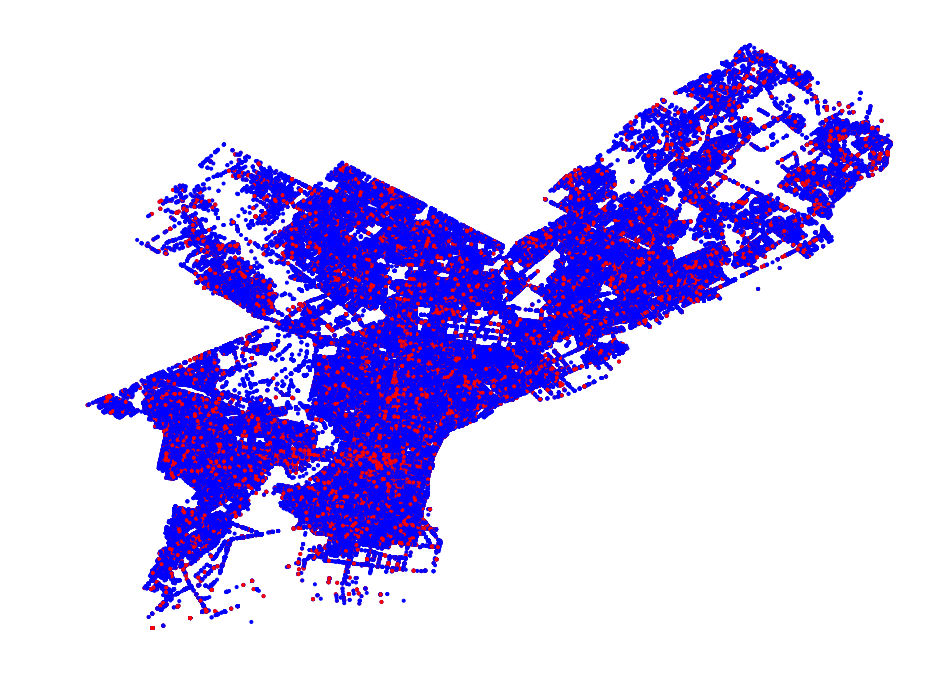

In [18]:
mixed_pts = list(zip(measured, ["r"] * len(measured))) + list(zip(baseline, ["b"] * len(baseline)))
random.shuffle(mixed_pts)
xs = get_coord(0, [p[0] for p in mixed_pts])
ys = get_coord(1, [p[0] for p in mixed_pts])
cs = [p[1] for p in mixed_pts]
f, ax = plt.subplots(figsize=(16, 12))
ax.set_axis_off()
ax.scatter(xs, ys, color=cs, marker='.')
plt.show()

## Subsampling 
It easy to use pyscan to extract an interesting region. The first step in most of the default scanning algorithms is contructing a "net" of points to define the regions of interest. This net can be created by taking a sample of the measured points and a sample of the baseline points and unioning them.

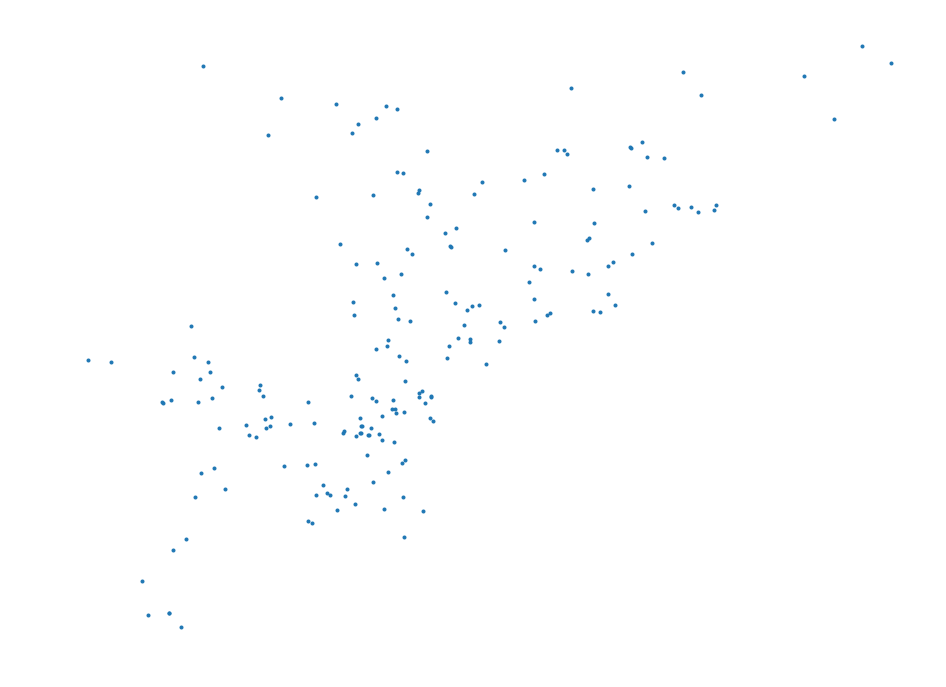

In [9]:
net = pyscan.my_sample(measured, 100) + pyscan.my_sample(baseline, 100)
f, ax = plt.subplots(figsize=(16, 12))
ax.set_axis_off()
ax.scatter(get_coord(0, net), get_coord(1, net), marker='.')
plt.show()

We also take a sample of the measured points and a sample of the baseline points. A good rule of thumb is that your measured and baseline samples should be roughly 1/4 * len(net)^2, so in this example the sample sizes should be 5000.

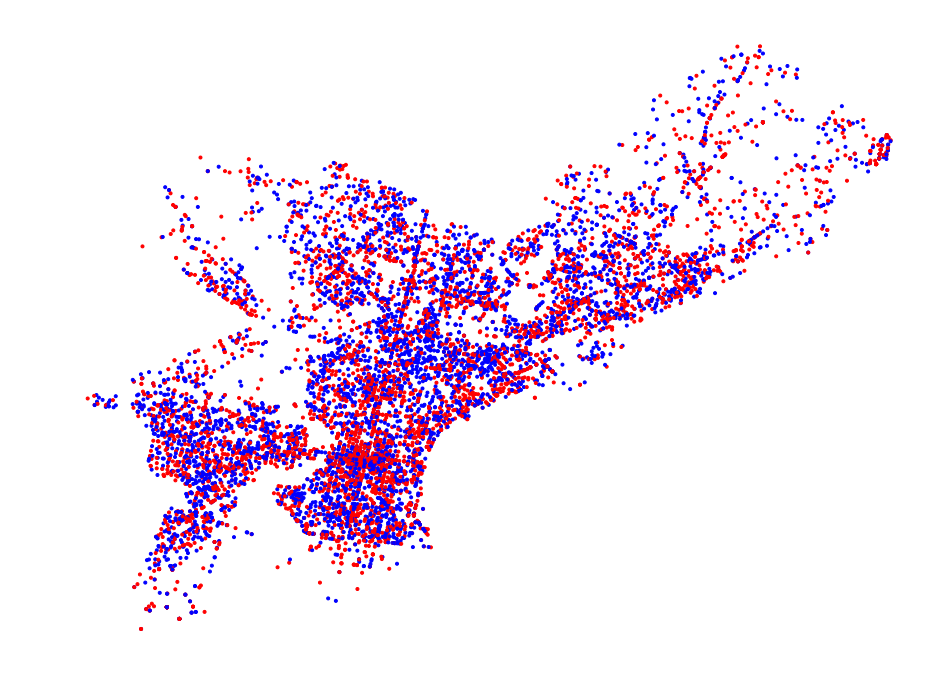

In [10]:
#take the samples
m_sample = pyscan.my_sample(measured, 5000) 
b_sample = pyscan.my_sample(baseline, 5000)

#plot the samples
mixed_samples = list(zip(m_sample, ["r"] * len(m_sample))) + list(zip(b_sample, ["b"] * len(b_sample)))
random.shuffle(mixed_samples)
xs = get_coord(0, [p[0] for p in mixed_samples])
ys = get_coord(1, [p[0] for p in mixed_samples])
cs = [p[1] for p in mixed_samples]
_, ax = plt.subplots(figsize=(16, 12))
ax.set_axis_off()
ax.scatter(xs, ys, color=cs, marker='.')
plt.show()

Using the combination of the net and sample we can scan the point set using one of the various pyscan scanning functions.
## Halfplane Scanning

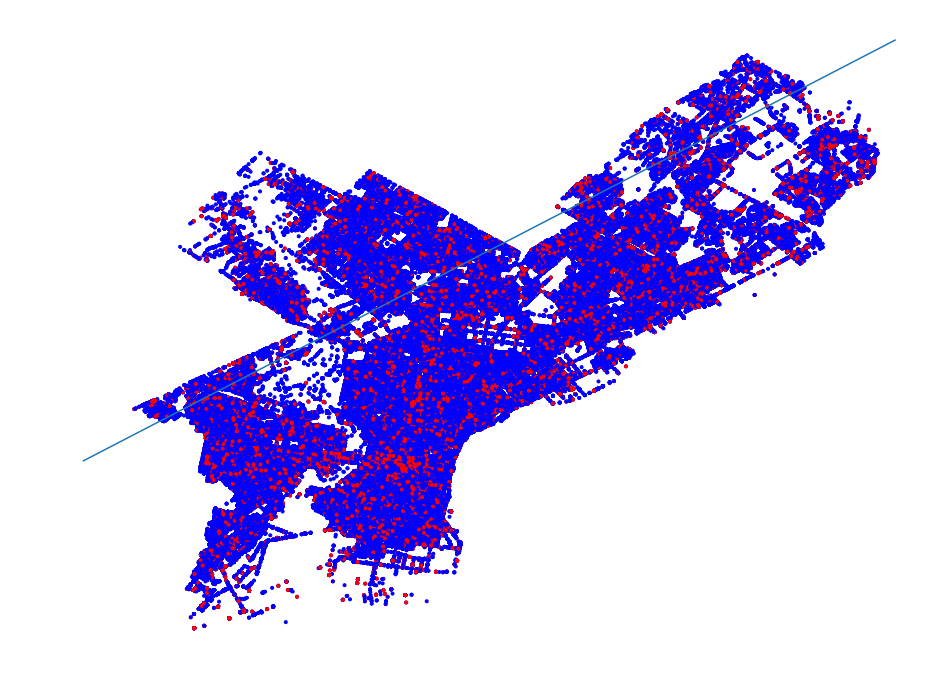

In [20]:
disc_f = pyscan.KULLDORF
halfplane, h_val = pyscan.max_halfplane(net, m_sample, b_sample, disc_f)


# l = (a, b, c) where ax + by + c = 0 => (-ax -c) / b = y
def f(mr, x):
    l = mr.get_coords()
    return -(x * l[0] + l[2]) / l[1]
    
_, ax = plt.subplots(figsize=(16, 12))
ax.set_axis_off()
ax.scatter(xs, ys, color=cs, marker='.')
ax.plot([-75.3, -74.95], [f(halfplane, -75.2), f(halfplane, -74.95)])
plt.show()


## Disk Scanning

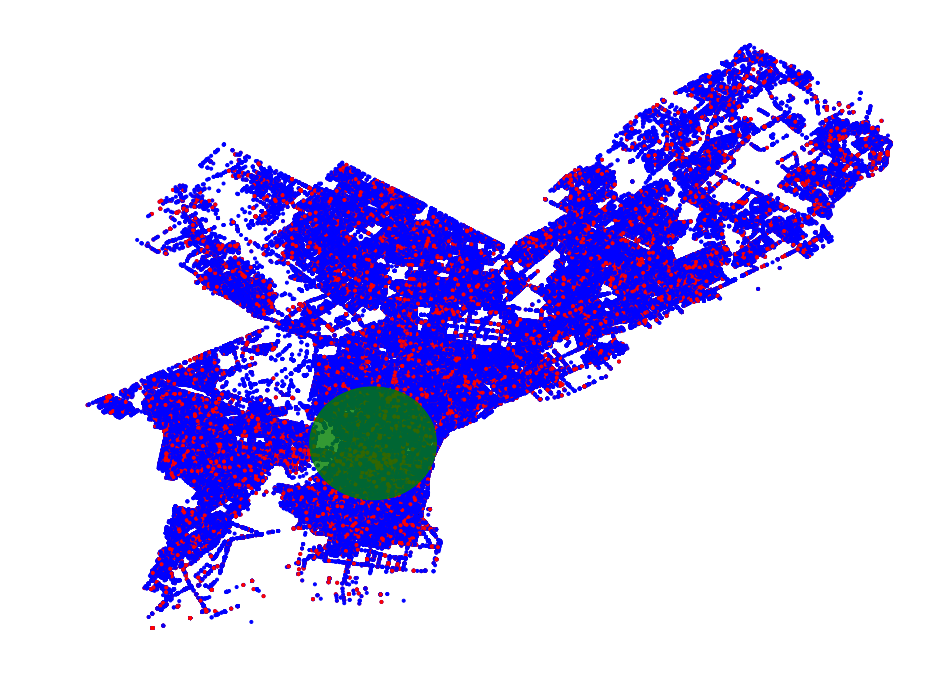

In [21]:
disk, d_val = pyscan.max_disk(net, m_sample, b_sample, disc_f)

# Plot disk
_, ax = plt.subplots(figsize=(16, 12))
ax.set_axis_off()
ax.scatter(xs, ys, color=cs, marker='.')
d = plt.Circle(disk.get_origin(), disk.get_radius(), color='g', alpha=.8)
ax.add_artist(d)
plt.show()

## Rectangle Scanning
Rectangle scanning by default doesn't use a point "net" though it is possible to use a net if needed.

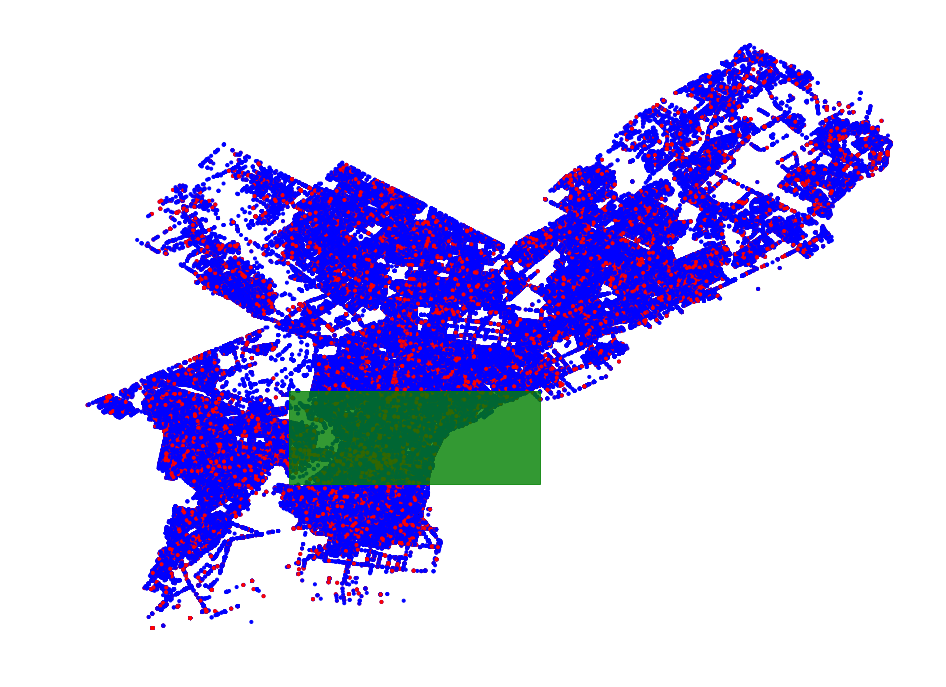

In [22]:
# all of these methods create a grid first and then scan the grid using various methods.
grid = pyscan.Grid(100, m_sample, b_sample)

# a slow exact method 
subgrid = pyscan.max_subgrid(grid, disc_f)
rect = grid.toRectangle(subgrid)

_, ax = plt.subplots(figsize=(16, 12))
ax.set_axis_off()
ax.scatter(xs, ys, color=cs, marker='.')
r = plt.Rectangle((rect.lowX(), rect.lowY()), rect.upX() - rect.lowX(), rect.upY() - rect.lowY(), 
                  alpha=.8, 
                  color='g')
ax.add_artist(r)
plt.show()

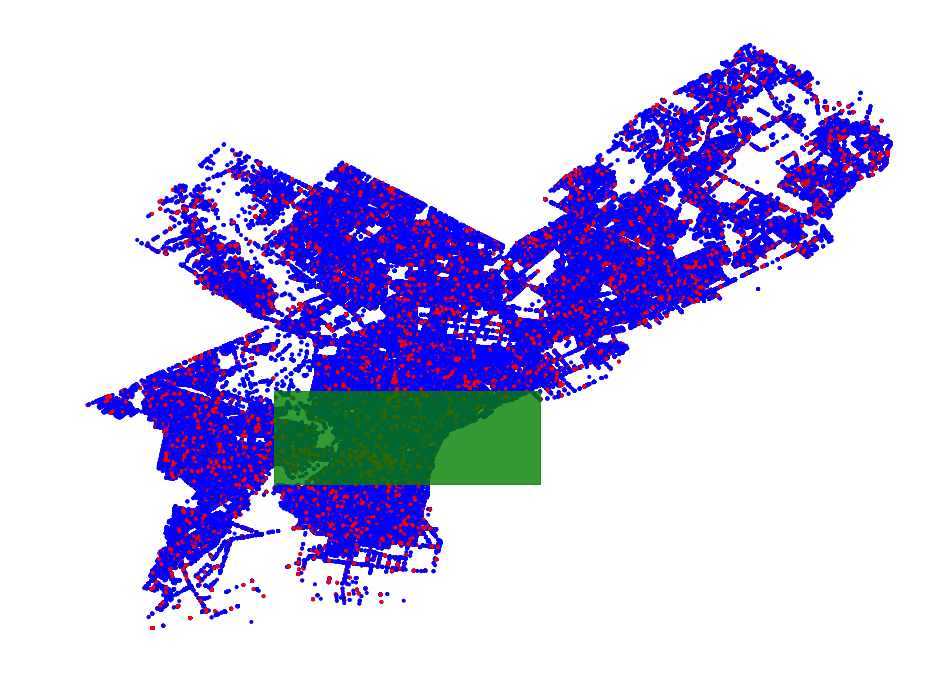

In [26]:
# a faster approximate method. Recommend you use the RKULLDORF method for this since the standard Kulldorf
# function can be a bit unstable for small and very large regions.
disc_f = pyscan.RKULLDORF

subgrid = pyscan.max_subgrid_convex(grid, .01, disc_f)
rect = grid.toRectangle(subgrid)

_, ax = plt.subplots(figsize=(16, 12))
ax.set_axis_off()
ax.scatter(xs, ys, color=cs, marker='.')
r = plt.Rectangle((rect.lowX(), rect.lowY()), rect.upX() - rect.lowX(), rect.upY() - rect.lowY(), 
                  alpha=.8, 
                  color='g')
ax.add_artist(r)
plt.show()